# Niche detection using scimap's `spatial_count` and `spatial_cluster`

In [1]:
## Imports
import scimap as sm
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import glob
import time
from sklearn.metrics import adjusted_rand_score

Running SCIMAP  2.1.3


/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
## Load data

cluster_labels = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/model201710_cluster_labels_phenograph_recoded.csv')
fn_2D = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_2D/measured_mask_centroids_2D_*.csv"
files_2D = np.array(glob.glob(fn_2D)) ## unsorted list of files (full path)
centroids_2D = pd.concat([pd.read_csv(file) for file in files_2D])
centroids_3D = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_3D.csv')

centroids_2D.sort_values(by='z', inplace=True)
## Recode cluster labels to avoid conversion to int in sm function (issue opened)
cluster_labels.loc[ cluster_labels['ct_broad'].isna(), 'ct_broad' ] = 'label_' + cluster_labels.loc[ cluster_labels['ct_broad'].isna(), 'phenograph' ].astype(str)
## Group T cell subtypes together (T, T_CD8a-)
cluster_labels.loc[ cluster_labels['ct_broad']=='T_CD8a-', 'ct_broad' ] = 'T'

## Merge cluster labels with centroids
data2D = pd.merge(centroids_2D, cluster_labels, on='id') ## id = cell id, z = imageid
data3D = pd.merge(centroids_3D, cluster_labels, on='id') ## id = cell id
data3D['imageid'] = np.repeat('imageid', data3D.shape[0]) ## placeholder

## To AnnData object
adata2 = ad.AnnData(obs=data2D)
adata3 = ad.AnnData(obs=data3D)

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



In [3]:
## Get NBH size equivalent
knn_2D = 10
knn2to3 = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/knn_2D_to_3D.csv')
knn_3D = knn2to3.loc[ knn2to3['knn_2D'] == knn_2D, 'knn_3D'].values[0]
knn_3D

39

### 3D data

In [4]:
## spatial_count
t0 = time.process_time()
sm.tl.spatial_count(adata3, phenotype='ct_broad', x_coordinate='x', y_coordinate='y', z_coordinate='z',
                    method='knn', knn=knn_3D, verbose=False)
print("Time elapsed: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

Time elapsed data:  00:00:15


In [5]:
## Compute niches for different number of niches k
ks = [3,7,11]

for k in ks:
    sm.tl.spatial_cluster(adata3, method='kmeans', label=f'spatial_kmeans_{k}', k=k, random_state=42, verbose=False)

Kmeans clustering
Kmeans clustering
Kmeans clustering


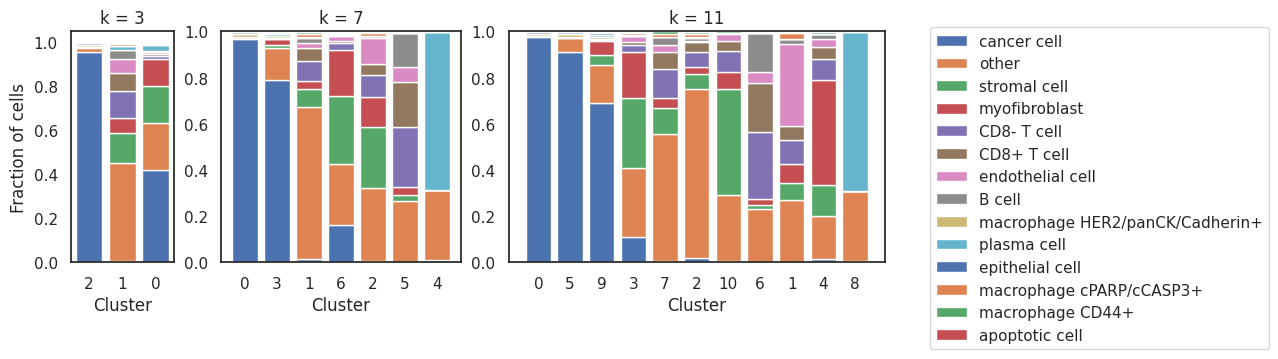

In [6]:
## Cluster composition plot
phenotype = 'ct_broad'

fig, ax = plt.subplots(1,len(ks), figsize=(np.array(ks).sum() / 2, 3), width_ratios=ks)
for i, k in enumerate(ks):
    # Compute cluster composition
    df = adata3.obs.groupby([f'spatial_kmeans_{k}', phenotype]).size().unstack().fillna(0).T ## number of cells per type (rows) and cluster (columns)
    df = df / adata3.obs[f'spatial_kmeans_{k}'].value_counts()[df.columns] ## fraction per cluster
    #df = df[ df.columns.astype(int).sort_values().astype(str) ] ## sort clusters numerically
    df = df[ adata3.obs[f'spatial_kmeans_{k}'].value_counts().sort_values(ascending=False).index ] ## sort clusters by cluster abundance (n_cells per cluster)
    df = df.loc[ adata3.obs[phenotype].value_counts().sort_values(ascending=False).index ] ## sort cell types by (total) abundance
    # Plot
    bottom = np.zeros(df.columns.size)
    for ct, values in df.iterrows():
        ax[i].bar(df.columns, values, bottom=bottom, label=ct)
        bottom += values
    ax[i].set_title(f'k = {k}')
    ax[i].set_xlabel('Cluster')
ax[0].set_ylabel('Fraction of cells')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

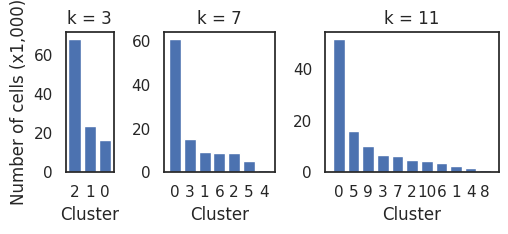

In [7]:
## Cluster abundance plot
fig, ax = plt.subplots(1,len(ks), figsize=(np.array(ks).sum() / 4, 2.5), width_ratios=ks)
for i, k in enumerate(ks):
    ccounts = adata3.obs[f'spatial_kmeans_{k}'].value_counts().sort_index() / 1000
    ccounts.sort_values(ascending=False, inplace=True) ## sort by cluster abundance
    ax[i].bar(ccounts.index, ccounts.values)
    ax[i].set_xticks(ccounts.index)
    ax[i].set_xlabel('Cluster')
    ax[i].set_title(f'k = {k}')
ax[0].set_ylabel('Number of cells (x1,000)')
plt.tight_layout()
plt.show()

### Results per 2D section

In [8]:
ks = [3, 7, 11]

spatial_kmeans = {}
for z in adata2.obs['z'].unique():
    adata = adata2[ adata2.obs['z']==z ].copy()
    sm.tl.spatial_count(adata, phenotype='ct_broad', x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z',
                        method='knn', knn=knn_2D, verbose=False)
    for k in ks:
        sm.tl.spatial_cluster(adata, method='kmeans', label=f'spatial_kmeans_{k}', k=k, random_state=42, verbose=False)
    spatial_kmeans[z] = adata.obs.set_index('id').filter(like='spatial_kmeans')

Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clustering
Kmeans clu

In [9]:
## Assess clustering similarity: ARI
ari = {}
img_ids = adata2.obs['z'].unique()
for k in ks:
    results = np.empty(img_ids.size)
    for i, img_id in enumerate(img_ids):
        ## Match cells between 2D and 3D by id
        adata2_subset = spatial_kmeans[img_id][f'spatial_kmeans_{k}']
        adata3_ids = adata3.obs.set_index('id').loc[ adata2_subset.index, f'spatial_kmeans_{k}'].astype(float).values
        adata2_ids = adata2_subset.astype(float).values
        ## Remove NaNs in either vector
        adata3_ids = adata3_ids[ ~np.isnan(adata3_ids) & ~np.isnan(adata2_ids) ].astype(int)
        adata2_ids = adata2_ids[ ~np.isnan(adata3_ids) & ~np.isnan(adata2_ids) ].astype(int)
        if not len(adata3_ids): ## No cells
            results[i] = np.nan
        else: ## Calculate adjusted rand index
            results[i] = adjusted_rand_score(adata3_ids, adata2_ids)
    ari[k] = results

In [67]:
## Select exemplary sections for plotting
k_select = 3
sections = [
    img_ids[ari[k_select].argmax()],
    #np.argwhere(ari[k_select] < .64)[1][0],
    #np.argwhere(ari[k_select] < .64)[-3][0],
    np.argwhere(ari[k_select] < .64)[-1][0]
    ]
sections

[144, 149]

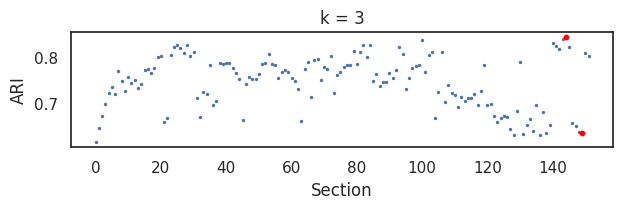

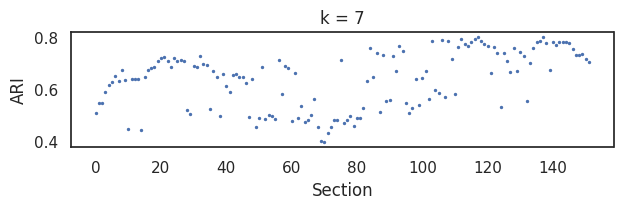

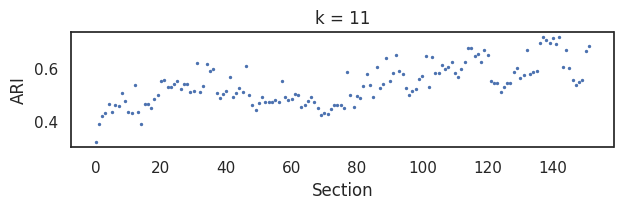

In [53]:
## Plot ARI
for k in ks:
    plt.subplots(figsize=(7,1.5))
    plt.title(f'k = {k}')
    plt.scatter(img_ids, ari[k], s=2)
    if k == k_select:
        plt.scatter(sections, ari[k][sections], c='red', s=10)
    plt.xlabel('Section')
    plt.ylabel('ARI')
    plt.show()

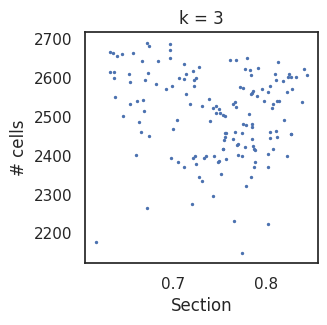

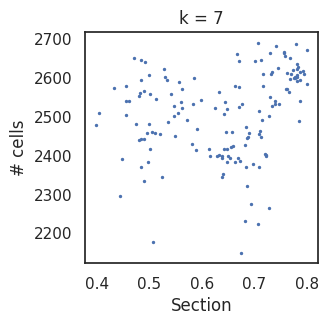

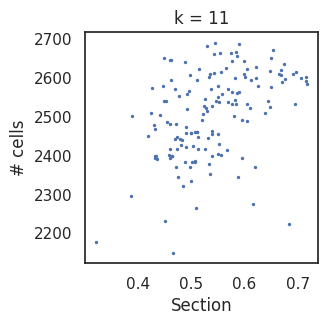

In [239]:
## Is the ARI related to the number of cells in the image?
for k in ks:
    plt.subplots(figsize=(3,3))
    plt.title(f'k = {k}')
    plt.scatter(ari[k], adata2.obs['z'].value_counts()[img_ids].values, s=2)
    plt.xlabel('Section')
    plt.ylabel('# cells')
    plt.show()

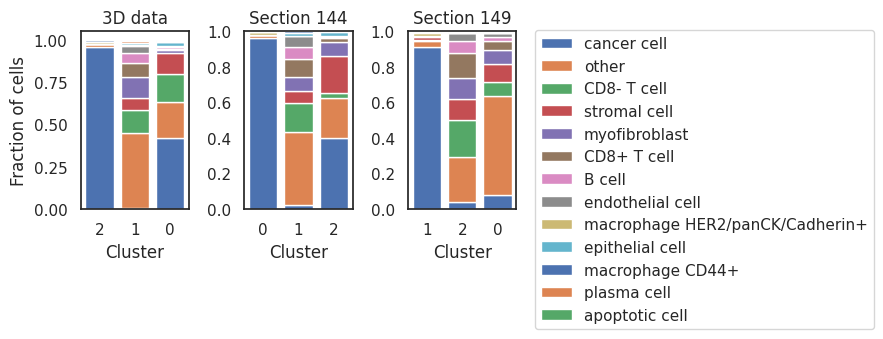

In [54]:
## Plot cluster composition for exemplary sections
phenotype = 'ct_broad'
k = k_select

# For 3D data ('true' clusters)
df = adata3.obs.groupby([f'spatial_kmeans_{k}', phenotype]).size().unstack().fillna(0).T ## number of cells per type (rows) and cluster (columns)
df = df / adata3.obs[f'spatial_kmeans_{k}'].value_counts()[df.columns] ## fraction per cluster
#df = df[ df.columns.astype(int).sort_values().astype(str) ] ## sort clusters numerically
df = df[ adata3.obs[f'spatial_kmeans_{k}'].value_counts().sort_values(ascending=False).index ] ## sort clusters by cluster abundance (n_cells per cluster)
df = df.loc[ adata3.obs[phenotype].value_counts().sort_values(ascending=False).index ] ## sort cell types by (total) abundance

# Start plot
fig, ax = plt.subplots(1,len(sections)+1, figsize=(k * (len(sections)+1), 3))
bottom = np.zeros(df.columns.size)
for ct, values in df.iterrows():
    ax[0].bar(df.columns, values, bottom=bottom, label=ct)
    bottom += values
ax[0].set_title('3D data')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Fraction of cells')

# For 2D data (exemplary)
for i, section in enumerate(sections):
    clusters2 = spatial_kmeans[section][f'spatial_kmeans_{k}'].copy()
    df2 = pd.DataFrame({'cluster': clusters2.values, 'phenotype': adata3.obs.set_index('id').loc[ clusters2.index, phenotype].values })

    df = df2.groupby(['cluster', 'phenotype']).size().unstack().fillna(0).T ## number of cells per type (rows) and cluster (columns)
    df = df / df2['cluster'].value_counts()[df.columns] ## fraction per cluster
    #df = df[ df.columns.astype(int).sort_values().astype(str) ] ## sort clusters numerically
    df = df[ df2['cluster'].value_counts().sort_values(ascending=False).index ] ## sort clusters by cluster abundance (n_cells per cluster)
    df = df.loc[ df2['phenotype'].value_counts().sort_values(ascending=False).index ] ## sort cell types by (total) abundance

    # Plot
    ax[i+1].set_title(f'Section {section}')
    bottom = np.zeros(df.columns.size)
    for ct, values in df.iterrows():
        ax[i+1].bar(df.columns, values, bottom=bottom, label=ct)
        bottom += values
    ax[i+1].set_xlabel('Cluster')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.show()

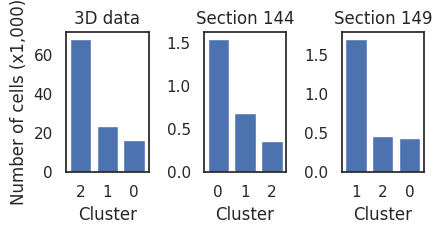

In [55]:
## Cluster abundance plot
# Note: 3D plot is across whole image, not just the section (since niches are not equivalent)

fig, ax = plt.subplots(1,len(sections)+1, figsize=((len(sections)+1)*1.5, 2.5))
# 3D data
ccounts = adata3.obs[f'spatial_kmeans_{k}'].value_counts() / 1000
ccounts.sort_values(ascending=False, inplace=True) ## sort by cluster abundance
ax[0].bar(ccounts.index, ccounts.values)
ax[0].set_xticks(ccounts.index)
ax[0].set_xlabel('Cluster')
ax[0].set_title('3D data')

for i, section in enumerate(sections):
    ccounts = spatial_kmeans[section][f'spatial_kmeans_{k}'].value_counts() / 1000
    ccounts.sort_values(ascending=False, inplace=True) ## sort by cluster abundance
    ax[i+1].bar(ccounts.index, ccounts.values)
    ax[i+1].set_xticks(ccounts.index)
    ax[i+1].set_xlabel('Cluster')
    ax[i+1].set_title(f'Section {section}')
ax[0].set_ylabel('Number of cells (x1,000)')
plt.tight_layout()
plt.show()

In [69]:
k_select = 3
sections = [
    img_ids[ari[k_select].argmax()],
    np.argwhere(ari[k_select] < .64)[1][0],
    np.argwhere(ari[k_select] < .64)[-3][0],
    np.argwhere(ari[k_select] < .64)[-1][0]
    ]

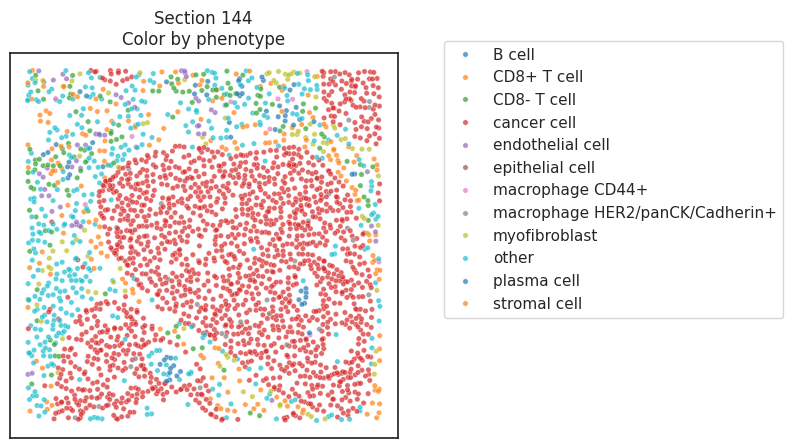

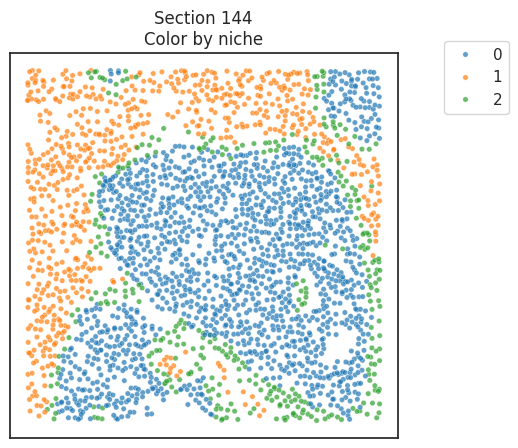

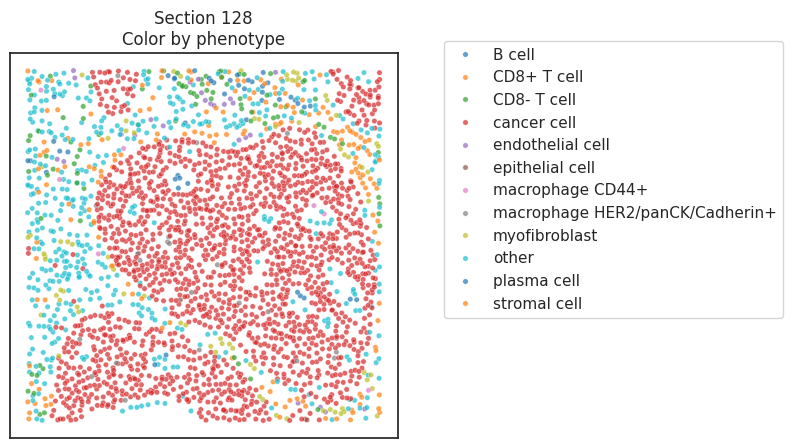

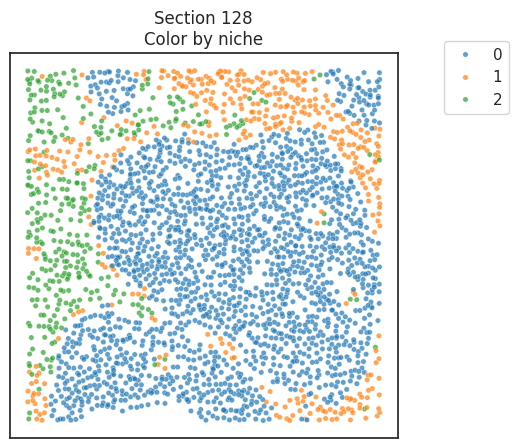

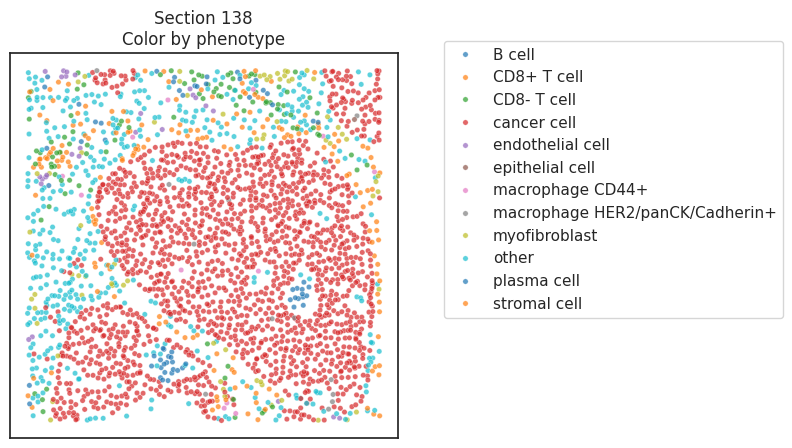

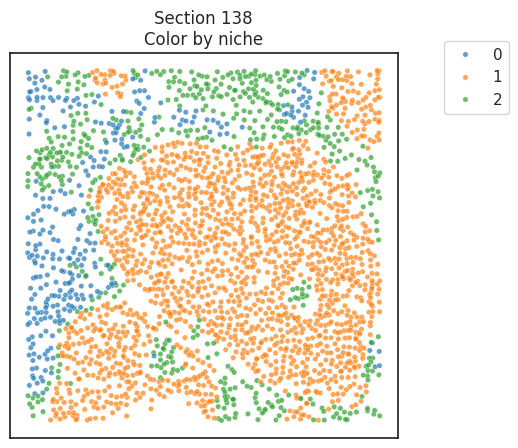

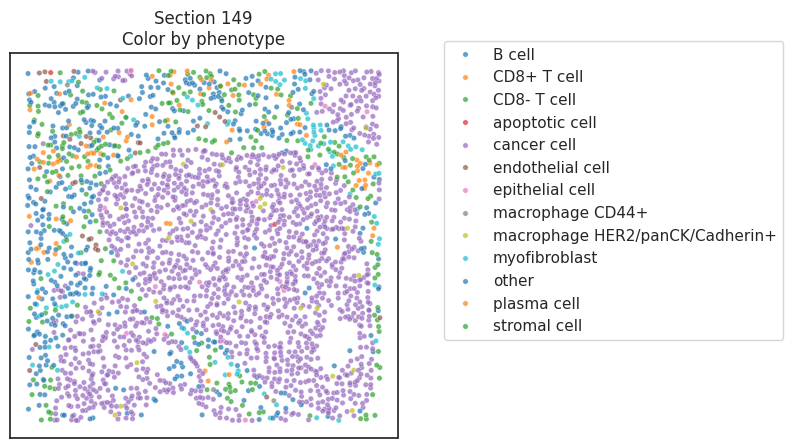

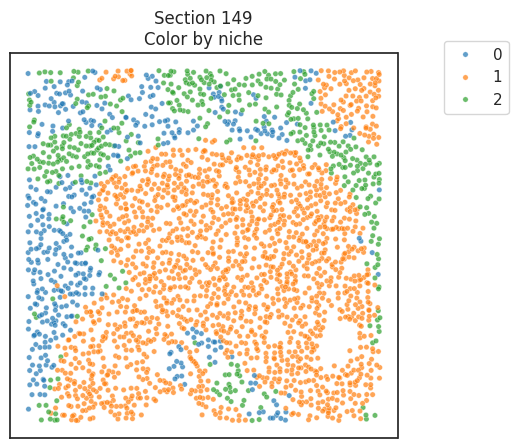

In [107]:
## Plot niche assignments on sections
import seaborn as sns
for section in sections:
    clusters2 = spatial_kmeans[section][f'spatial_kmeans_{k_select}'].copy()
    df2 = pd.DataFrame({
        'niche': clusters2.values,
        'phenotype': adata3.obs.set_index('id').loc[ clusters2.index, 'ct_broad'].values,
        'x': adata3.obs.set_index('id').loc[ clusters2.index, 'x'].values,
        'y': adata3.obs.set_index('id').loc[ clusters2.index, 'y'].values })
    for i, cat in enumerate(['phenotype','niche']):
        fig, ax = plt.subplots(figsize=(5,5))
        sns.scatterplot(ax=ax,
            x=df2['x'], y=df2['y'],
            hue=df2[cat].astype('category').values,
            palette='tab10',
            s=15, alpha=.7)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(f'Section {section}\nColor by {cat}')
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.show()

### Using all 2D data
Note that cells can be present in several sections, i.e., there are "counted multiple times".

In [56]:
## spatial_count
t0 = time.process_time()
sm.tl.spatial_count(adata2, phenotype='ct_broad', x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z',
                    method='knn', knn=knn_2D, verbose=False)
print("Time elapsed: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

Time elapsed:  00:00:13


In [57]:
## Compute niches for different number of niches k
ks = [3,7,11]

for k in ks:
    sm.tl.spatial_cluster(adata2, method='kmeans', label=f'spatial_kmeans_{k}', k=k, random_state=42, verbose=False)

Kmeans clustering
Kmeans clustering
Kmeans clustering


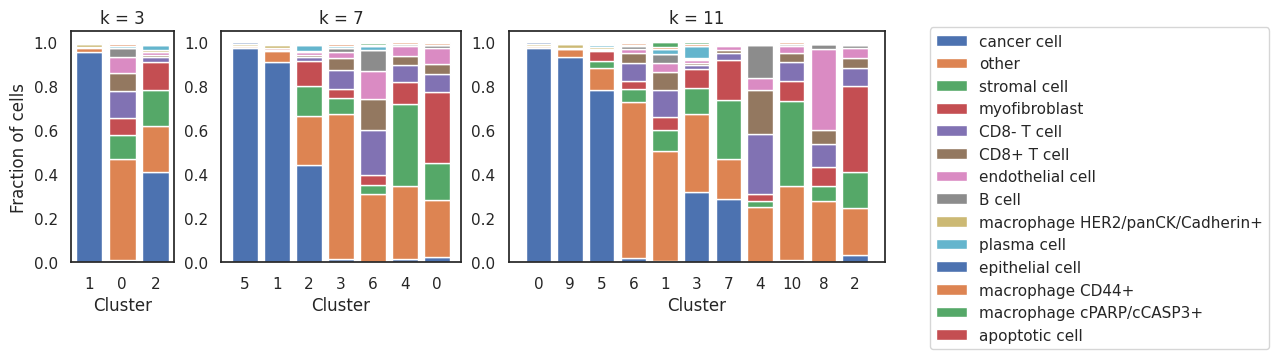

In [58]:
## Cluster composition plot
phenotype = 'ct_broad'

fig, ax = plt.subplots(1,len(ks), figsize=(np.array(ks).sum() / 2, 3), width_ratios=ks)
for i, k in enumerate(ks):
    # Compute cluster composition
    df = adata2.obs.groupby([f'spatial_kmeans_{k}', phenotype]).size().unstack().fillna(0).T ## number of cells per type (rows) and cluster (columns)
    df = df / adata2.obs[f'spatial_kmeans_{k}'].value_counts()[df.columns] ## fraction per cluster
    #df = df[ df.columns.astype(int).sort_values().astype(str) ] ## sort clusters numerically
    df = df[ adata2.obs[f'spatial_kmeans_{k}'].value_counts().sort_values(ascending=False).index ] ## sort clusters by cluster abundance (n_cells per cluster)
    df = df.loc[ adata2.obs[phenotype].value_counts().sort_values(ascending=False).index ] ## sort cell types by (total) abundance
    # Plot
    bottom = np.zeros(df.columns.size)
    for ct, values in df.iterrows():
        ax[i].bar(df.columns, values, bottom=bottom, label=ct)
        bottom += values
    ax[i].set_title(f'k = {k}')
    ax[i].set_xlabel('Cluster')
ax[0].set_ylabel('Fraction of cells')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

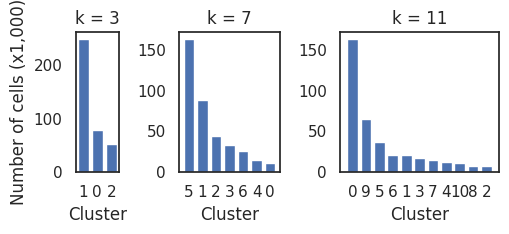

In [59]:
## Cluster abundance plot
fig, ax = plt.subplots(1,len(ks), figsize=(np.array(ks).sum() / 4, 2.5), width_ratios=ks)
for i, k in enumerate(ks):
    ccounts = adata2.obs[f'spatial_kmeans_{k}'].value_counts().sort_index() / 1000
    ccounts.sort_values(ascending=False, inplace=True) ## sort by cluster abundance
    ax[i].bar(ccounts.index, ccounts.values)
    ax[i].set_xticks(ccounts.index)
    ax[i].set_xlabel('Cluster')
    ax[i].set_title(f'k = {k}')
ax[0].set_ylabel('Number of cells (x1,000)')
plt.tight_layout()
plt.show()

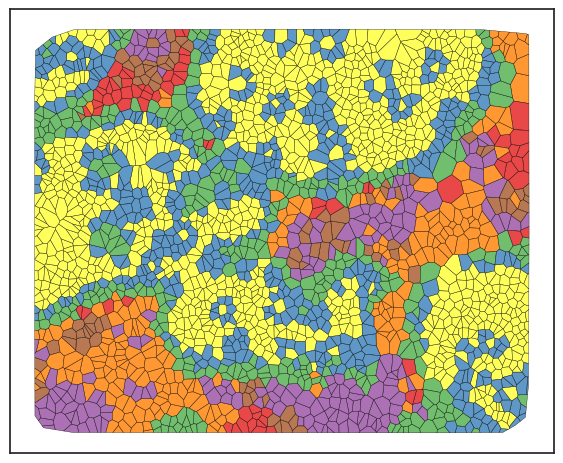

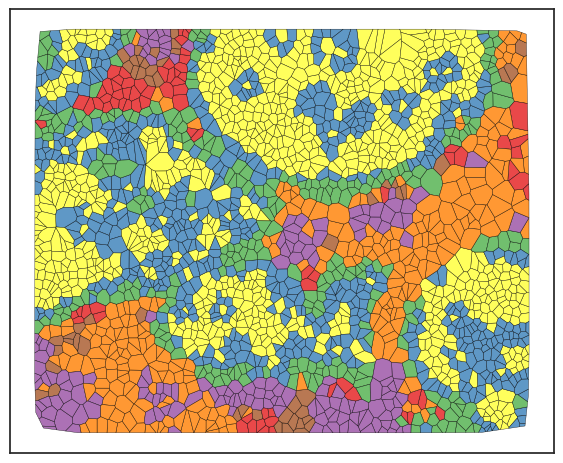

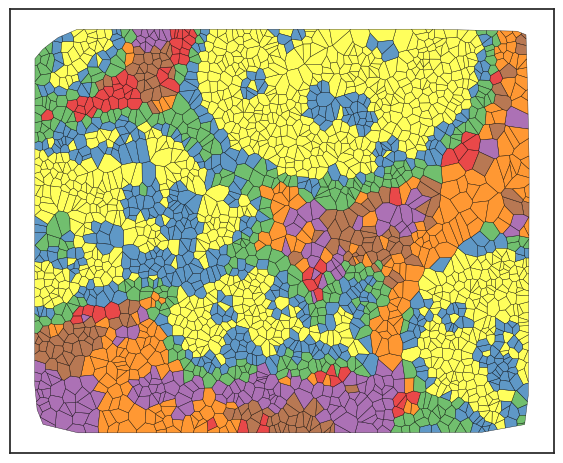

In [13]:
## Plot results on exemplary 2D images
k = 7

rng = np.random.default_rng(42)
subset = rng.choice(adata2.obs['z'].unique(), 1)

for i in range(3):
    sm.pl.voronoi(adata2, subset=subset[0]+i, imageid='z',
                x_coordinate='x', y_coordinate='y',
                color_by=f'spatial_kmeans_{k}', 
                voronoi_edge_color = 'black',
                voronoi_line_width = 0.3, 
                voronoi_alpha = 0.8, 
                size_max=3000,
                overlay_points=None, 
                plot_legend=True, # FIXME: legend not showing
                legend_size=6)